In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext rpy2.ipython

In [4]:
import numpy as np
import pandas as pd

from kaggle.house_prices.notebook import Plot

In [5]:
from rpy2 import robjects
from rpy2.robjects.lib import ggplot2 as gg

robjects.pandas2ri.activate()

In [7]:
from kaggle.house_prices import helpers
from kaggle.house_prices import outliers

combined_dataset = helpers.load_data()
training_dataset = combined_dataset.query("dataSource == 'train'")

In [8]:
#check some basic invariants

combined_strange_cases = outliers.get_strange_cases(combined_dataset)
combined_outliers_removed = outliers.remove_outliers(combined_dataset)

training_strange_cases = outliers.get_strange_cases(training_dataset)
training_outliers_removed = outliers.remove_outliers(training_dataset)

assert len(combined_strange_cases) + len(combined_outliers_removed) == len(combined_dataset)
assert len(training_strange_cases) + len(training_outliers_removed) == len(training_dataset)
pd.testing.assert_frame_equal(combined_strange_cases, training_strange_cases)

In [23]:
#
# SPDANM - deviation of price from neighborhood's median price
# price_per_sq - price per living area square feet
#
def calc_quality(q):
    if q in (1, 2, 3):
        return 'Bad'
    if q in (4, 5, 6):
        return 'Fair'
    if q in (7, 8):
        return 'Good'
    return 'Excellent'


def calc_SPDANM(df):
    median = (
        df
        .groupby('Neighborhood')
        ['SalePrice']
        .transform(np.median)
    )
    return df['SalePrice'] - median
    

training_dataset2 = (
    training_dataset
    .assign(
        quality=lambda df: df['OverallQual'].apply(calc_quality),
        price_per_sq=lambda df: df['SalePrice'] / df['GrLivArea'],
        SPDANM=calc_SPDANM
    )
)
    

strange_cases = outliers.get_strange_cases(training_dataset2)
EdwardsExcellent = training_dataset2.query("Neighborhood == 'Edwards'and quality == 'Excellent'")

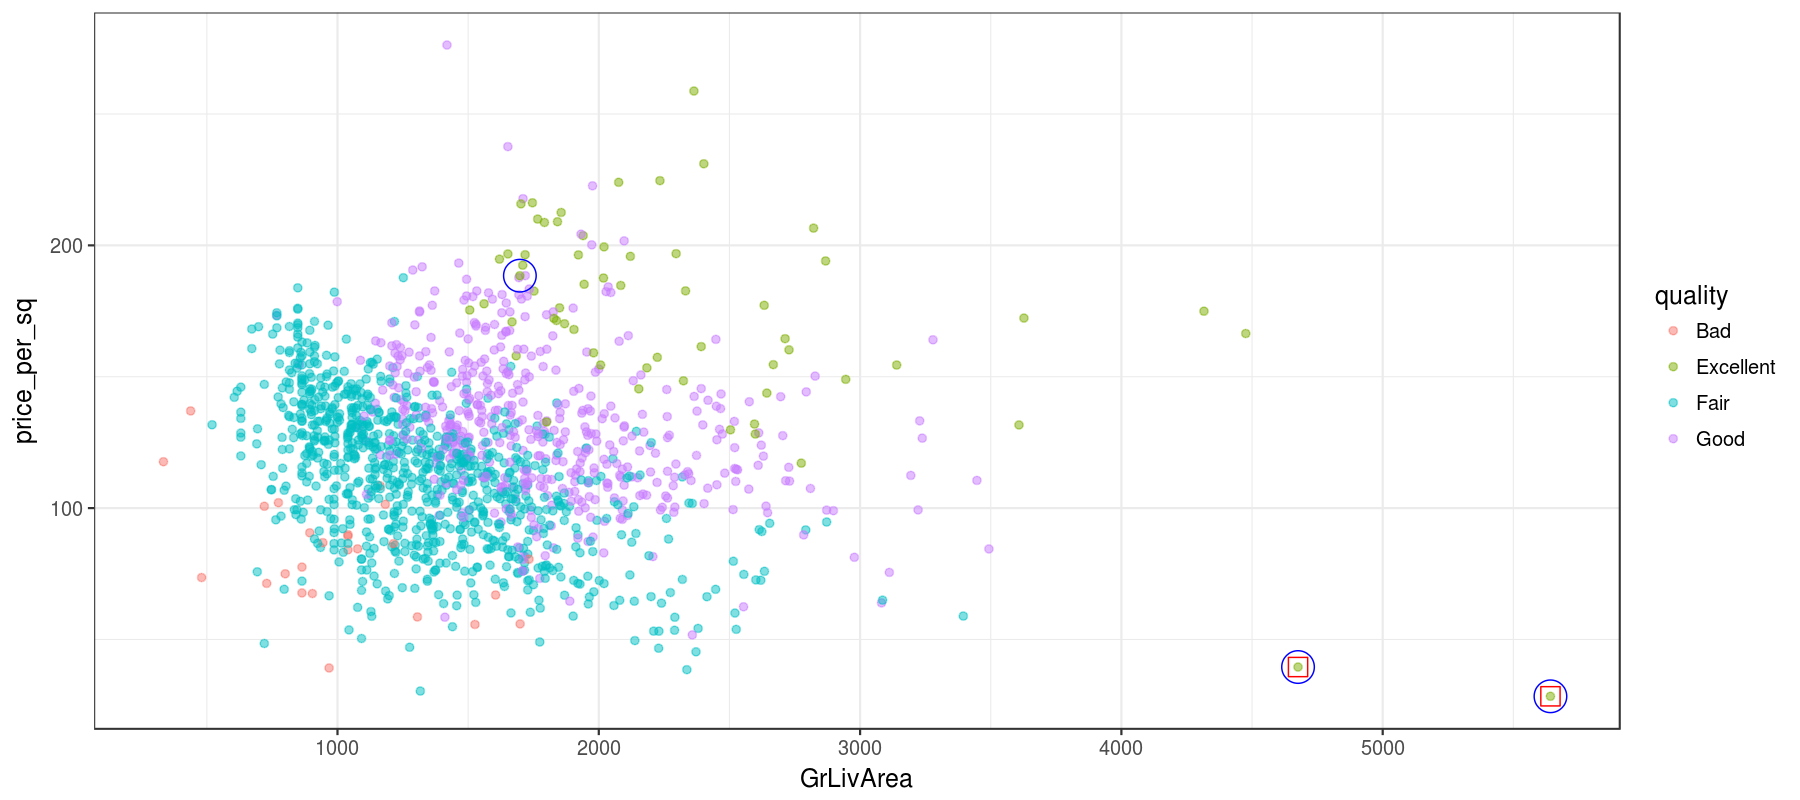

In [33]:
with Plot(width=1800, height=800, res=150) as plot:
    plot(
        gg.ggplot(training_dataset2) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='price_per_sq', color='quality'), alpha=0.5) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='price_per_sq'), 
                           data=strange_cases, colour="red", size=4, shape=0) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='price_per_sq'), 
                   data=EdwardsExcellent, colour="blue", size=7, shape=1) +
        gg.theme_bw()
    ) 

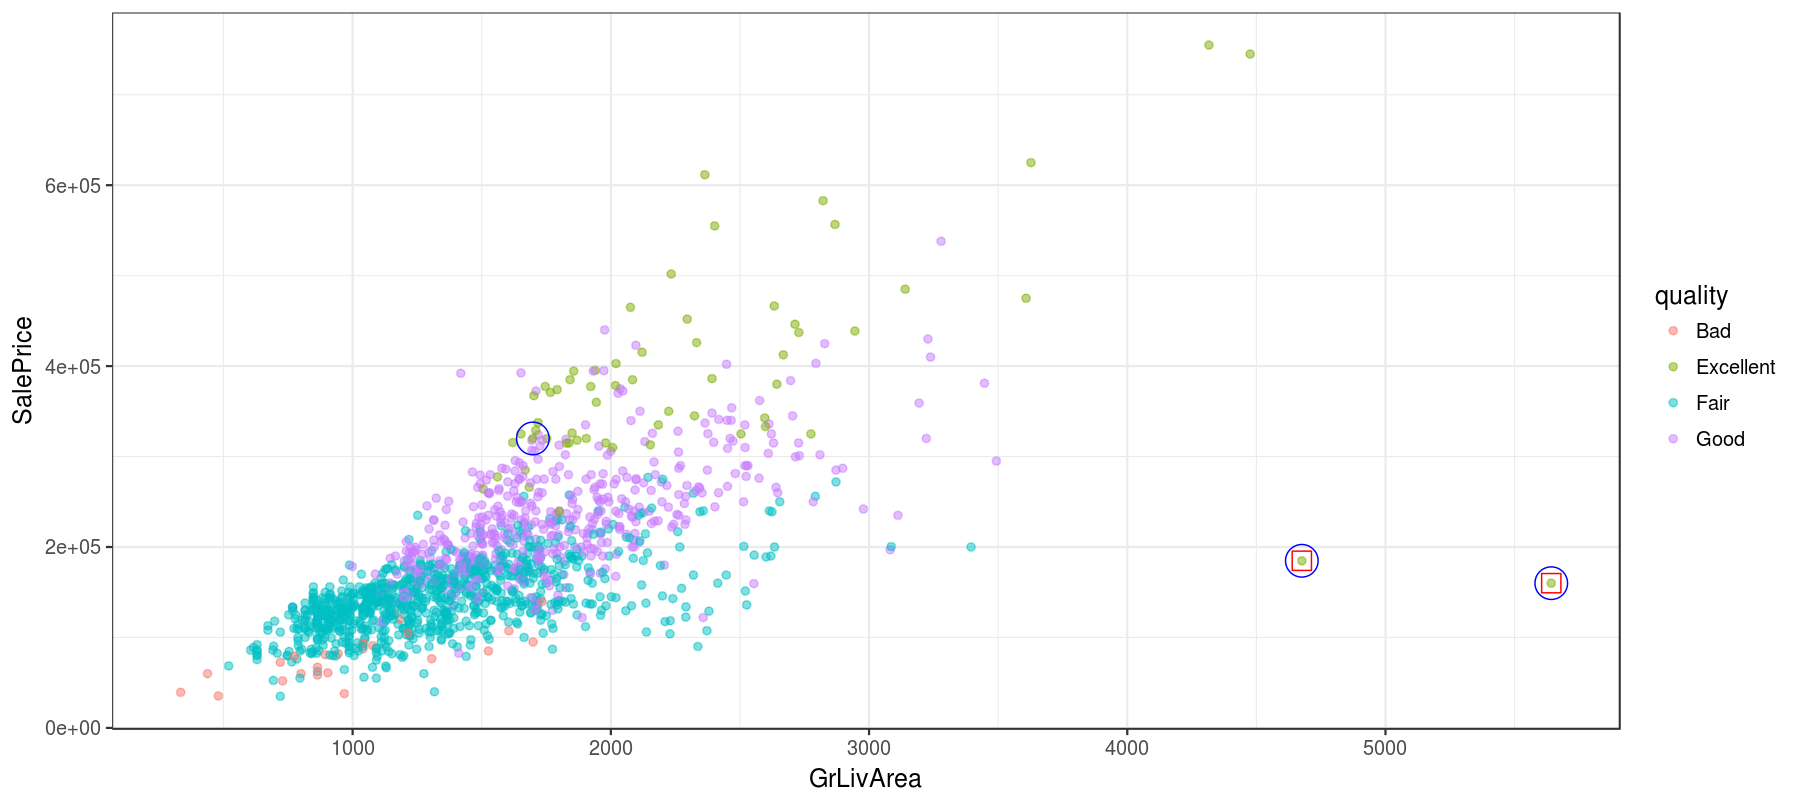

In [34]:
with Plot(width=1800, height=800, res=150) as plot:
    plot(
        gg.ggplot(training_dataset2) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SalePrice', color='quality'), alpha=0.5) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SalePrice'), 
                           data=strange_cases, colour="red", size=4, shape=0) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SalePrice'), 
                   data=EdwardsExcellent, colour="blue", size=7, shape=1) +
        gg.theme_bw()
    ) 

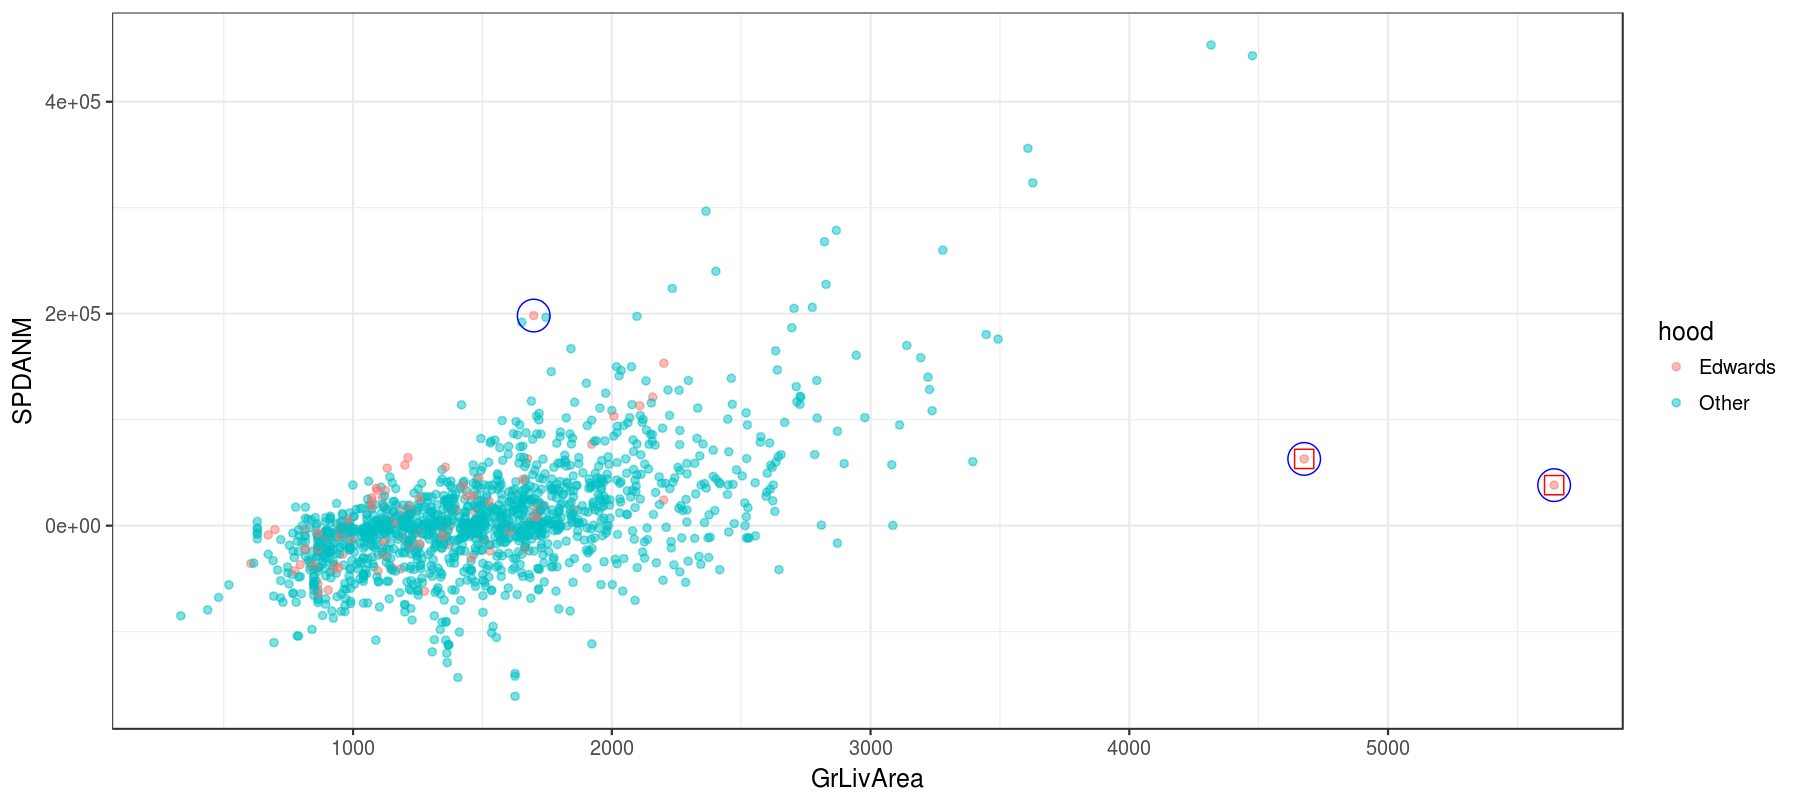

In [36]:
df = (
    training_dataset2
    .assign(
        hood = lambda df: df['Neighborhood'].apply(lambda x: 'Edwards' if x == 'Edwards' else 'Other')
    )
)

with Plot(width=1800, height=800, res=150) as plot:
    plot(
        gg.ggplot(df) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SPDANM', color='hood'), alpha=0.5) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SPDANM'), 
                           data=strange_cases, colour="red", size=4, shape=0) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SPDANM'), 
                   data=EdwardsExcellent, colour="blue", size=7, shape=1) +
        gg.theme_bw()
    ) 

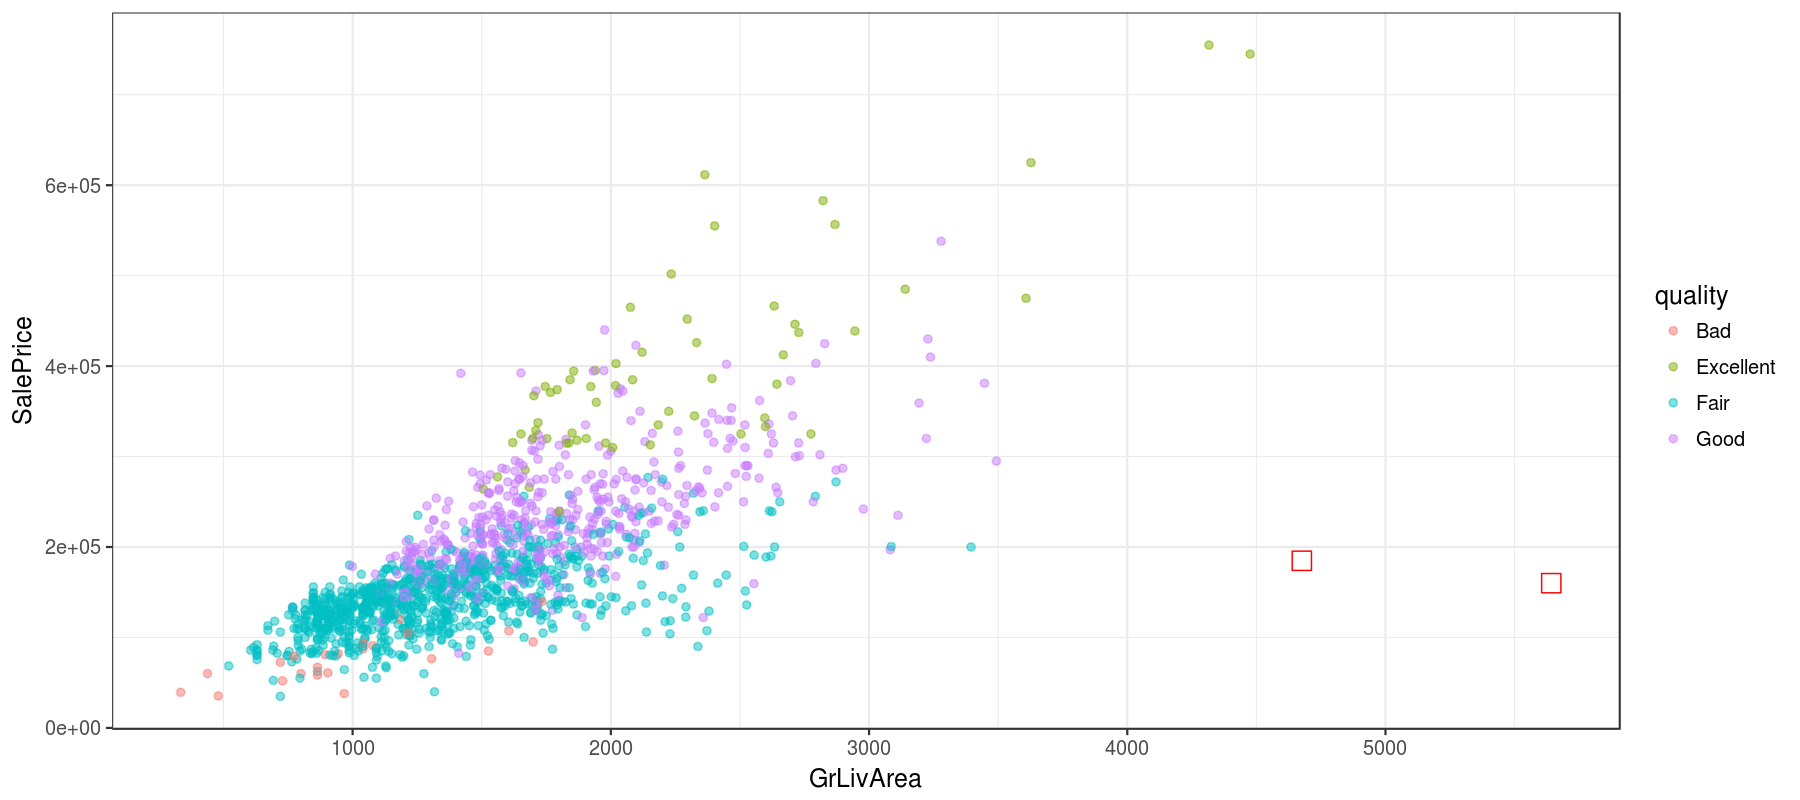

In [37]:
with Plot(width=1800, height=800, res=150) as plot:
    plot(
        gg.ggplot(outliers.remove_outliers(training_dataset2)) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SalePrice', color='quality'), alpha=0.5) +
        gg.geom_point(gg.aes_string(x='GrLivArea', y='SalePrice'), 
                           data=strange_cases, colour="red", size=4, shape=0) +
        gg.theme_bw()
    ) 